In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import layers, models, callbacks


In [2]:
# Muat dataset
X = np.load('all_beat_segments.npy')
y = np.load('all_beat_labels_encoded.npy')

In [3]:
# Pastikan ukuran dataset
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (109459, 89)
y shape: (109459,)


In [4]:
# Split dataset: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [5]:
# Reshape untuk model Bi-LSTM (batch_size, time_steps, features)
X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)


In [6]:
# Encode label ke one-hot
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [7]:
# Definisi Attention Layer
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], 1),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name="att_bias",
            shape=(input_shape[1], 1),
            initializer='zeros',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.matmul(x, self.W) + self.b  # Shape: (batch_size, time_steps, 1)
        et = tf.squeeze(et, axis=-1)       # Shape: (batch_size, time_steps)
        at = tf.nn.softmax(et)            # Softmax over time steps
        at = tf.expand_dims(at, axis=-1)  # Shape: (batch_size, time_steps, 1)
        output = x * at                    # Weighted input
        output = tf.reduce_sum(output, axis=1)  # Shape: (batch_size, features)
        return output

    def get_config(self):
        return super(AttentionLayer, self).get_config()


In [8]:
# Arsitektur Model
def build_attentive_bilstm(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Bidirectional LSTM
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(inputs)

    # Attention Layer
    attention = AttentionLayer()(x)

    # Dense Layers
    x = layers.Dense(64, activation='relu')(attention)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model



In [9]:
model = build_attentive_bilstm(input_shape=(X_train.shape[1], 1), num_classes=4)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 89, 1)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 89, 128)          33792     
 l)                                                              
                                                                 
 attention_layer (AttentionL  (None, 128)              217       
 ayer)                                                           
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260   

In [10]:
# Callbacks
checkpoint = callbacks.ModelCheckpoint(
    'best_model.h5', 
    monitor='val_accuracy', 
    save_best_only=True
)
early_stop = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Training
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=100,
    batch_size=64,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/100
1369/1369 [==============================] - 153s 109ms/step - loss: 0.3790 - accuracy: 0.8890 - val_loss: 0.2770 - val_accuracy: 0.9068
Epoch 2/100
1369/1369 [==============================] - 146s 106ms/step - loss: 0.2815 - accuracy: 0.9115 - val_loss: 0.2567 - val_accuracy: 0.9161
Epoch 3/100
1369/1369 [==============================] - 154s 113ms/step - loss: 0.2526 - accuracy: 0.9202 - val_loss: 0.2250 - val_accuracy: 0.9278
Epoch 4/100
1369/1369 [==============================] - 161s 118ms/step - loss: 0.2313 - accuracy: 0.9278 - val_loss: 0.2021 - val_accuracy: 0.9365
Epoch 5/100
1369/1369 [==============================] - 140s 102ms/step - loss: 0.2171 - accuracy: 0.9324 - val_loss: 0.1975 - val_accuracy: 0.9382
Epoch 6/100
1369/1369 [==============================] - 135s 99ms/step - loss: 0.2058 - accuracy: 0.9356 - val_loss: 0.1977 - val_accuracy: 0.9384
Epoch 7/100
1369/1369 [==============================] - 198s 145ms/step - loss: 0.1989 - accuracy: 0.9377 

In [11]:
# Evaluasi
loss, acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {acc:.4f}")

plt.figure(figsize=(12, 4))


685/685 [==============================] - 42s 57ms/step - loss: 0.1476 - accuracy: 0.9520
Test Accuracy: 0.9520


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

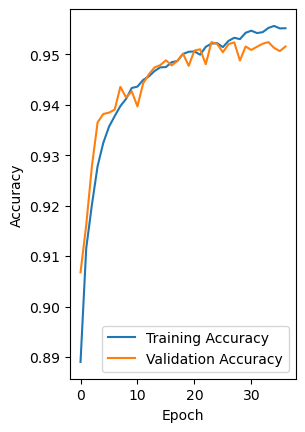

In [15]:
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

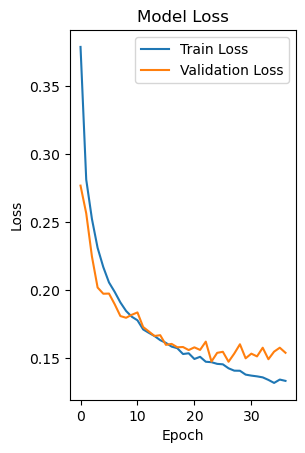

In [13]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [16]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [17]:
# Simpan model
model.save('attentive_bilstm_arrhythmia.h5')
print("Model disimpan sebagai 'attentive_bilstm_arrhythmia.h5'")

Model disimpan sebagai 'attentive_bilstm_arrhythmia.h5'
